In [ ]:
from google.colab import drive

# This will prompt you to click a link and get an authorization code
drive.mount('/content/gdrive')

In [ ]:
!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.0 MB/s eta 0:00:00


# Selecting data

In [ ]:
import pandas as pd
import os
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.signal import find_peaks
import numpy as np
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer, mean_absolute_error


os.chdir("/content/gdrive/MyDrive/DMP")
pd.set_option("display.precision", 2)

In [ ]:

import pandas as pd

people = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17']
columns_needed = ["Time[s]", "Delta_Time","MET", "value__bpm"]


data = []
for person in people:
    df = pd.read_pickle("merged_dataset/{0}/ALL.pkl".format(person))
    df_subset = df[columns_needed]
    df_subset['Person'] = person
    data.append(df_subset)


print(data[0])


<ipython-input-5-100c0cae2e30>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Person'] = person
<ipython-input-5-100c0cae2e30>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Person'] = person
<ipython-input-5-100c0cae2e30>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

                     Time[s]      Delta_Time   MET  value__bpm Person
Time                                                                 
2021-12-03 16:58:51      1.0 0 days 00:00:00  1.31        91.0     P1
2021-12-03 16:58:52      2.0 0 days 00:00:01  1.31        91.0     P1
2021-12-03 16:58:53      3.0 0 days 00:00:02  1.52        91.0     P1
2021-12-03 16:58:54      4.0 0 days 00:00:03  1.63        91.0     P1
2021-12-03 16:58:55      5.0 0 days 00:00:04  1.56        88.0     P1
...                      ...             ...   ...         ...    ...
2021-12-03 17:28:48   1798.0 0 days 00:29:57  5.32       139.0     P1
2021-12-03 17:28:49   1799.0 0 days 00:29:58  5.11       139.0     P1
2021-12-03 17:28:50   1800.0 0 days 00:29:59  4.46       142.0     P1
2021-12-03 17:28:51   1801.0 0 days 00:30:00  4.12       142.0     P1
2021-12-03 17:28:52   1802.0 0 days 00:30:01  4.43       142.0     P1

[1802 rows x 5 columns]


<ipython-input-5-100c0cae2e30>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Person'] = person


In [ ]:
data[0]

,Time[s],Delta_Time,MET,value__bpm,Person
Time,,,,,
2021-12-03 16:58:51,1.0,0 days 00:00:00,1.31,91.0,P1
2021-12-03 16:58:52,2.0,0 days 00:00:01,1.31,91.0,P1
2021-12-03 16:58:53,3.0,0 days 00:00:02,1.52,91.0,P1
2021-12-03 16:58:54,4.0,0 days 00:00:03,1.63,91.0,P1
2021-12-03 16:58:55,5.0,0 days 00:00:04,1.56,88.0,P1
...,...,...,...,...,...
2021-12-03 17:28:48,1798.0,0 days 00:29:57,5.32,139.0,P1
2021-12-03 17:28:49,1799.0,0 days 00:29:58,5.11,139.0,P1
2021-12-03 17:28:50,1800.0,0 days 00:29:59,4.46,142.0,P1


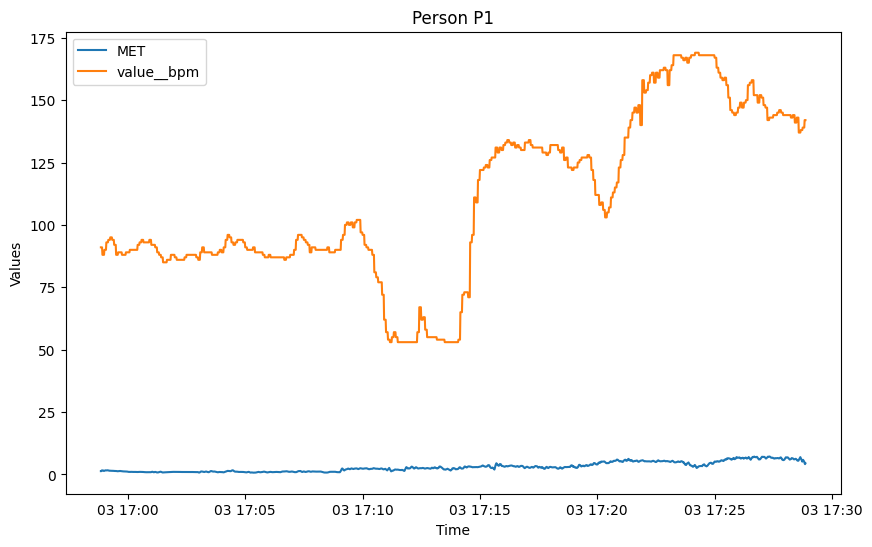

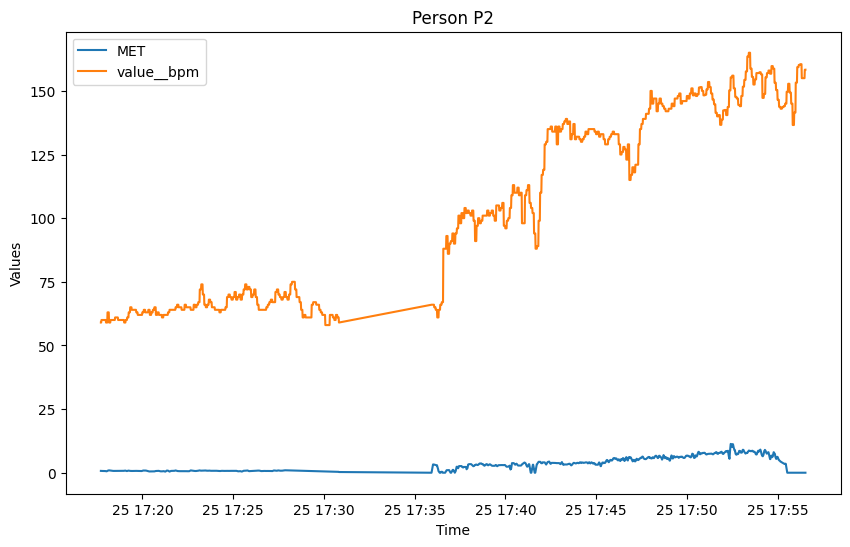

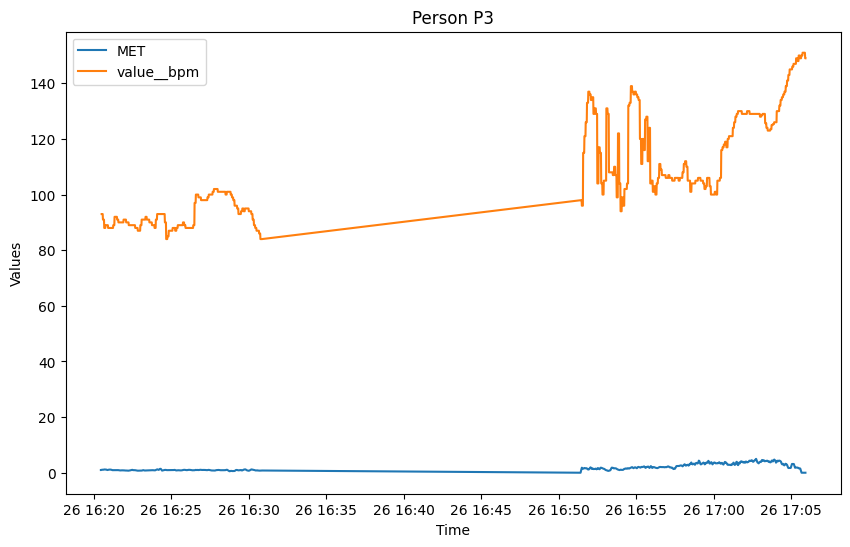

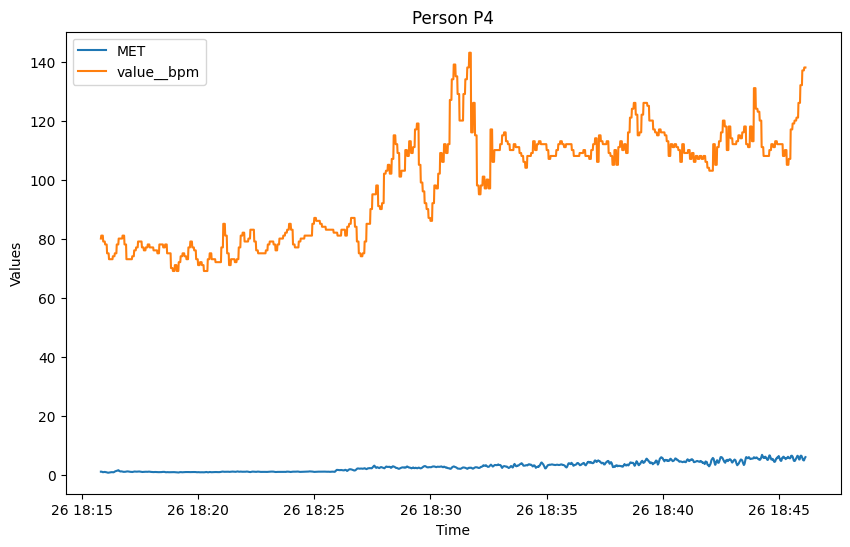

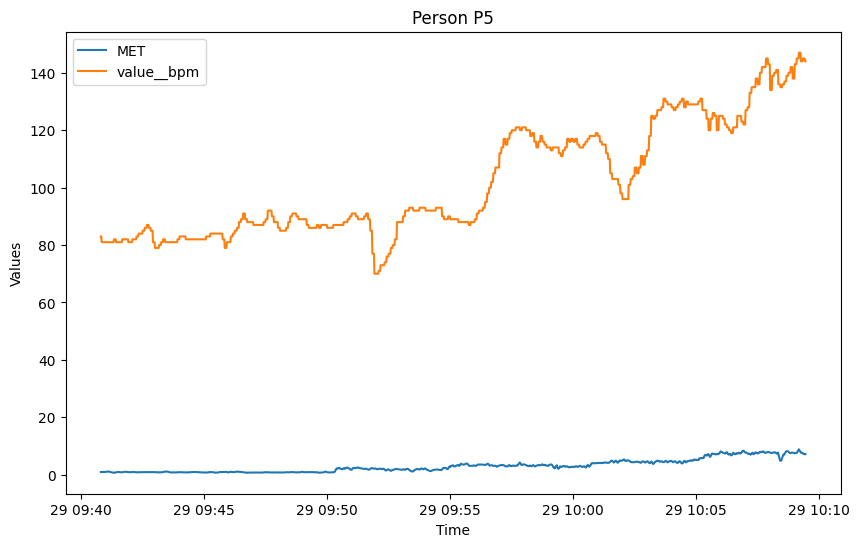

In [ ]:
import matplotlib.pyplot as plt

# Iterate over the data list
for i, df_subset in enumerate(data):
  if i < 5:
    person = people[i]

    # Extract MET and value__bpm columns
    MET = df_subset['MET']
    value_bpm = df_subset['value__bpm'].ffill()

    # Plot MET and value__bpm
    plt.figure(figsize=(10, 6))
    plt.plot(MET, label='MET')
    plt.plot(value_bpm, label='value__bpm')
    plt.title(f'Person {person}')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.show()


## Feature engineering

### Time lagged features

In [ ]:
columns_needed = columns_needed[-1:-1]

In [ ]:
time_lagged_features = True

def time_lagged_features(data, time_lags):
    for time_lag in time_lags:
        data['value__bpm_lag_b_{}'.format(time_lag)] = data['value__bpm'].shift(time_lag)
        data['value__bpm_lag_b_{}'.format(time_lag)].fillna(method='bfill', inplace=True)

        # Now create the forward lagged features
        data['value__bpm_lag_f_{}'.format(time_lag)] = data['value__bpm'].shift(-time_lag)
        data['value__bpm_lag_f_{}'.format(time_lag)].fillna(method='ffill', inplace=True)
    return data

if time_lagged_features:
    time_lags = [x for x in range(1,15,2) ]
    for i in range(len(data)):
        data[i] = time_lagged_features(data[i], time_lags)

    columns_needed = columns_needed + [col for col in data[0].columns if 'lag' in col]
    print(data[0])


                     Time[s]      Delta_Time   MET  value__bpm Person  \
Time                                                                    
2021-12-03 16:58:51      1.0 0 days 00:00:00  1.31        91.0     P1   
2021-12-03 16:58:52      2.0 0 days 00:00:01  1.31        91.0     P1   
2021-12-03 16:58:53      3.0 0 days 00:00:02  1.52        91.0     P1   
2021-12-03 16:58:54      4.0 0 days 00:00:03  1.63        91.0     P1   
2021-12-03 16:58:55      5.0 0 days 00:00:04  1.56        88.0     P1   
...                      ...             ...   ...         ...    ...   
2021-12-03 17:28:48   1798.0 0 days 00:29:57  5.32       139.0     P1   
2021-12-03 17:28:49   1799.0 0 days 00:29:58  5.11       139.0     P1   
2021-12-03 17:28:50   1800.0 0 days 00:29:59  4.46       142.0     P1   
2021-12-03 17:28:51   1801.0 0 days 00:30:00  4.12       142.0     P1   
2021-12-03 17:28:52   1802.0 0 days 00:30:01  4.43       142.0     P1   

                     value__bpm_lag_b_1  value__bp

<ipython-input-9-d95a63877743>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['value__bpm_lag_b_{}'.format(time_lag)] = data['value__bpm'].shift(time_lag)
<ipython-input-9-d95a63877743>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['value__bpm_lag_b_{}'.format(time_lag)].fillna(method='bfill', inplace=True)
<ipython-input-9-d95a63877743>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

## Model training

In [ ]:

concatenated_data = pd.concat(data, axis=0)

concatenated_data = concatenated_data.dropna()

X_data = concatenated_data[columns_needed].copy()
X_data = X_data.to_numpy()

Y_data = concatenated_data['MET']
Y_data = Y_data.to_numpy()
people = concatenated_data['Person']

In [ ]:
normalizer = MinMaxScaler()
X_data = normalizer.fit_transform(X_data)

### XGBoost with cross validation

#### Cross validation

In [ ]:


# Define the parameters grid
parameters_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [2, 3, 4, 5, 6]
}

# Create XGBRegressor model
model = XGBRegressor(colsample_bytree=0.56, subsample=0.3, min_child_weight=0.6)

# Define GroupKFold for cross-validation
group_kfold = GroupKFold(n_splits=17)

# Define mean absolute error as scoring metric
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform grid search with custom CV splitter
grid_search = GridSearchCV(model, parameters_grid, cv=group_kfold.split(X_data, Y_data, people), scoring=scorer, n_jobs=-1)
grid_search.fit(X_data, Y_data)

# Get results
print("Best parameters found:")
print(grid_search.best_params_)
print("Best mean absolute error found:", -grid_search.best_score_)


Best parameters found:
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
Best mean absolute error found: 1.1331864429285374


In [ ]:
import matplotlib.pyplot as plt
# Import MAE
from sklearn.metrics import mean_absolute_error
# Plot the actual MET and the predicted MET for participants
# print(X_data, Y_data, participants)
cv = [split for split in group_kfold.split(X_data, Y_data, people)]
cv = sorted(cv, key=lambda x: x[1][0], reverse=False)
for fold, participant in enumerate(cv):
    train_index, test_index = participant
    # print(train_index, test_index)
    X_train, X_test = X_data[train_index], X_data[test_index]
    Y_train, Y_test = Y_data[train_index], Y_data[test_index]
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.plot(Y_test, label='Actual MET')
    plt.plot(Y_pred, label='Predicted MET')
    plt.title('Participant {0} Fold {1}'.format(people[fold], fold+1))
    plt.legend()
    plt.show()

#CatBoost with cross validation

In [ ]:

parameters_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [2, 3, 4, 5, 6]
}

# Create CatBoostRegressor model
model = CatBoostRegressor()

# Define GroupKFold for cross-validation
group_kfold = GroupKFold(n_splits=17)

# Define mean absolute error as scoring metric
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform grid search
grid_search = GridSearchCV(model, parameters_grid, cv=group_kfold.split(X_data, Y_data, people), scoring=scorer, n_jobs=-1)
grid_search.fit(X_data, Y_data)

# Get results
print("Best parameters found:")
print(grid_search.best_params_)
print("Best mean absolute error found:", -grid_search.best_score_)


0:	learn: 2.2054178	total: 49.2ms	remaining: 24.5s
1:	learn: 2.1941956	total: 52.1ms	remaining: 13s
2:	learn: 2.1829840	total: 54.2ms	remaining: 8.98s
3:	learn: 2.1720069	total: 56.2ms	remaining: 6.97s
4:	learn: 2.1610904	total: 58.3ms	remaining: 5.77s
5:	learn: 2.1505216	total: 60.2ms	remaining: 4.96s
6:	learn: 2.1399731	total: 62.3ms	remaining: 4.39s
7:	learn: 2.1294878	total: 64.5ms	remaining: 3.96s
8:	learn: 2.1192400	total: 66.7ms	remaining: 3.64s
9:	learn: 2.1090650	total: 68.8ms	remaining: 3.37s
10:	learn: 2.0989473	total: 71ms	remaining: 3.16s
11:	learn: 2.0890570	total: 73.1ms	remaining: 2.97s
12:	learn: 2.0793573	total: 75.3ms	remaining: 2.82s
13:	learn: 2.0697771	total: 77.4ms	remaining: 2.69s
14:	learn: 2.0602665	total: 79.4ms	remaining: 2.56s
15:	learn: 2.0509913	total: 81.5ms	remaining: 2.46s
16:	learn: 2.0418808	total: 83.7ms	remaining: 2.38s
17:	learn: 2.0329021	total: 85.8ms	remaining: 2.3s
18:	learn: 2.0238672	total: 88.2ms	remaining: 2.23s
19:	learn: 2.0149133	total:

In [ ]:
import matplotlib.pyplot as plt
# Import MAE
from sklearn.metrics import mean_absolute_error
# Plot the actual MET and the predicted MET for participants
# print(X_data, Y_data, participants)
cv = [split for split in group_kfold.split(X_data, Y_data, people)]
cv = sorted(cv, key=lambda x: x[1][0], reverse=False)
for fold, participant in enumerate(cv):
    train_index, test_index = participant
    # print(train_index, test_index)
    X_train, X_test = X_data[train_index], X_data[test_index]
    Y_train, Y_test = Y_data[train_index], Y_data[test_index]
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.plot(Y_test, label='Actual MET')
    plt.plot(Y_pred, label='Predicted MET')
    plt.title('Participant {0} Fold {1}'.format(people[fold], fold+1))
    plt.legend()
    plt.show()